In [1]:
# Self Organizing Maps (Kohonen Maps)
#  unsupervised method
#  they are used for reducing the dimensionality
#  the mechanism behind it is based on distances


# K-Means Clustering
#  unsupervised method
#  used for clustering your data
#  the mechanism behind it is based on distances


# SOMs therefore are said to "preserve the topology" of the original data, because the distances in 2-D space 
# reflect those in the high-dimensional space. K-means also clusters similar data points together, but its final 
# "representation" is hard to visualise because it's not in a convenient 2-D format.

# Imports

In [2]:
import pandas as pd
import math
import datetime as dt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

from matplotlib import patches as patches
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout 

Using TensorFlow backend.
/home/andrei/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/andrei/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/andrei/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/andrei/.local/lib/python3.6/site-packa

# Descriptive analysis

The source of the data: https://www.kaggle.com/kyanyoga/sample-sales-data

In [3]:
data = pd.read_csv("sales_data_sample.csv", encoding = 'unicode_escape')

Change column names:

In [4]:
data.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')

In [5]:
data = data.rename(columns = {'ORDERNUMBER': 'ORDER_NUMBER', 
                              'QUANTITYORDERED': 'QUANTITY_ORDERED',
                              'PRICEEACH': 'PRICE_EACH',
                              'ORDERLINENUMBER': 'ORDER_LINE_NUMBER',
                              'SALES': 'TOTAL_VALUE_OF_THE_SALE',
                              'ORDERDATE': 'ORDER_DATE',
                              'STATUS': 'STATUS_OF_THE_SALE',
                              'QTR_ID': 'QUARTER_ID',
                              'MONTH_ID': 'MONTH_ID',
                              'YEAR_ID': 'YEAR_ID',
                              'PRODUCTLINE': 'PRODUCT_LINE',
                              'MSRP': 'MANUFACTURER_SUGGESTED_RETAIL_PRICE',
                              'PRODUCTCODE': 'PRODUCT_CODE',
                              'CUSTOMERNAME': 'CUSTOMER_NAME',
                              'PHONE': 'PHONE',
                              'ADDRESSLINE1': 'ADDRESS_LINE_1',
                              'ADDRESSLINE2': 'ADDRESS_LINE_2',
                              'CITY': 'CITY',
                              'STATE': 'STATE',
                              'POSTALCODE': 'POSTAL_CODE',
                              'COUNTRY': 'COUNTRY',
                              'TERRITORY': 'TERRITORY',
                              'CONTACTLASTNAME': 'CONTACT_LAST_NAME',
                              'CONTACTFIRSTNAME': 'CONTACT_FIRST_NAME',
                              'DEALSIZE': 'DEAL_SIZE'
                             })

Fix the bugs:

- wrong values in 'PRICE_EACH' column;
- wrong values in 'TERRITORY' column.

In [6]:
data['PRICE_EACH'] = data['TOTAL_VALUE_OF_THE_SALE'] / data['QUANTITY_ORDERED']

In [7]:
for row in range(len(data['TERRITORY'])):
    if(data['TERRITORY'][row] == 'Japan'):
        data['TERRITORY'][row] = 'APAC' # APAC = Asia Pacific Region
    
for row in range(len(data['TERRITORY'])):
    if(type(data['TERRITORY'][row]) == float):
        if(math.isnan(data['TERRITORY'][row])):
            data['TERRITORY'][row] = 'NA' # NA = North America

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Check how many unique values has each column:

In [8]:
data.nunique()

ORDER_NUMBER                            307
QUANTITY_ORDERED                         58
PRICE_EACH                             2157
ORDER_LINE_NUMBER                        18
TOTAL_VALUE_OF_THE_SALE                2763
ORDER_DATE                              252
STATUS_OF_THE_SALE                        6
QUARTER_ID                                4
MONTH_ID                                 12
YEAR_ID                                   3
PRODUCT_LINE                              7
MANUFACTURER_SUGGESTED_RETAIL_PRICE      80
PRODUCT_CODE                            109
CUSTOMER_NAME                            92
PHONE                                    91
ADDRESS_LINE_1                           92
ADDRESS_LINE_2                            9
CITY                                     73
STATE                                    16
POSTAL_CODE                              73
COUNTRY                                  19
TERRITORY                                 3
CONTACT_LAST_NAME               

In [9]:
print('ORDER_LINE_NUMBER:', data['ORDER_LINE_NUMBER'].unique())
print('STATUS_OF_THE_SALE:', data['STATUS_OF_THE_SALE'].unique())
print('QUARTER_ID:', data['QUARTER_ID'].unique())
print('MONTH_ID:', data['MONTH_ID'].unique())
print('YEAR_ID:', data['YEAR_ID'].unique())
print('PRODUCT_LINE:', data['PRODUCT_LINE'].unique())
print('ADDRESS_LINE_2:', data['ADDRESS_LINE_2'].unique())
print('TERRITORY:', data['TERRITORY'].unique())
print('DEAL_SIZE:', data['DEAL_SIZE'].unique())

ORDER_LINE_NUMBER: [ 2  5  6 14  1  9  7 13 12  4 11  8  3 10 17 16 15 18]
STATUS_OF_THE_SALE: ['Shipped' 'Disputed' 'In Process' 'Cancelled' 'On Hold' 'Resolved']
QUARTER_ID: [1 2 3 4]
MONTH_ID: [ 2  5  7  8 10 11 12  1  4  6  9  3]
YEAR_ID: [2003 2004 2005]
PRODUCT_LINE: ['Motorcycles' 'Classic Cars' 'Trucks and Buses' 'Vintage Cars' 'Planes'
 'Ships' 'Trains']
ADDRESS_LINE_2: [nan 'Level 3' 'Suite 101' 'Level 6' 'Suite 750' 'Level 15' '2nd Floor'
 'Suite 400' 'Floor No. 4' 'Suite 200']
TERRITORY: ['NA' 'EMEA' 'APAC']
DEAL_SIZE: ['Small' 'Medium' 'Large']


The shape of the data:

- 2823 rows

- 25 columns

In [10]:
data.shape

(2823, 25)

After having a look at the first five observations, we realized that some columns have NaN values:

- ADDRESS_LINE_2
- STATE
- POSTAL_CODE

In [11]:
data.head()

,ORDER_NUMBER,QUANTITY_ORDERED,PRICE_EACH,ORDER_LINE_NUMBER,TOTAL_VALUE_OF_THE_SALE,ORDER_DATE,STATUS_OF_THE_SALE,QUARTER_ID,MONTH_ID,YEAR_ID,...,ADDRESS_LINE_1,ADDRESS_LINE_2,CITY,STATE,POSTAL_CODE,COUNTRY,TERRITORY,CONTACT_LAST_NAME,CONTACT_FIRST_NAME,DEAL_SIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NA,Young,Julie,Medium
4,10159,49,106.23,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NA,Brown,Julie,Medium


Same situation as above.

In [12]:
data.tail()

,ORDER_NUMBER,QUANTITY_ORDERED,PRICE_EACH,ORDER_LINE_NUMBER,TOTAL_VALUE_OF_THE_SALE,ORDER_DATE,STATUS_OF_THE_SALE,QUARTER_ID,MONTH_ID,YEAR_ID,...,ADDRESS_LINE_1,ADDRESS_LINE_2,CITY,STATE,POSTAL_CODE,COUNTRY,TERRITORY,CONTACT_LAST_NAME,CONTACT_FIRST_NAME,DEAL_SIZE
2818,10350,20,112.22,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,137.19,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,...,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium
2820,10386,43,125.99,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,...,1 rue Alsace-Lorraine,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small
2822,10414,47,65.52,9,3079.44,5/6/2005 0:00,On Hold,2,5,2005,...,8616 Spinnaker Dr.,NaN,Boston,MA,51003,USA,NA,Yoshido,Juri,Medium


Data information:

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ORDER_NUMBER                         2823 non-null   int64  
 1   QUANTITY_ORDERED                     2823 non-null   int64  
 2   PRICE_EACH                           2823 non-null   float64
 3   ORDER_LINE_NUMBER                    2823 non-null   int64  
 4   TOTAL_VALUE_OF_THE_SALE              2823 non-null   float64
 5   ORDER_DATE                           2823 non-null   object 
 6   STATUS_OF_THE_SALE                   2823 non-null   object 
 7   QUARTER_ID                           2823 non-null   int64  
 8   MONTH_ID                             2823 non-null   int64  
 9   YEAR_ID                              2823 non-null   int64  
 10  PRODUCT_LINE                         2823 non-null   object 
 11  MANUFACTURER_SUGGESTED_RETAIL_

Decisions taken after understanding the data:

- change the data type for column 'ORDER_DATE';
- we can remove 'CONTACT_FIRST_NAME' and 'CONTACT_LAST_NAME' since we have 'CUSTOMER_NAME' => we can identify the company without having the contact first name or the contact last name;
- some variables are not significant for our analysis: 'PHONE', 'ADDRESS_LINE_1', 'ADDRESS_LINE_2', 'POSTAL_CODE' => we can remove these variables.

In [14]:
data['ORDER_DATE'][0]

'2/24/2003 0:00'

In [15]:
data['ORDER_DATE'] = pd.to_datetime(data['ORDER_DATE'])

In [16]:
data['ORDER_DATE'][0]

Timestamp('2003-02-24 00:00:00')

In [17]:
data['ORDER_DATE'] = [d.date() for d in data['ORDER_DATE']]

In [18]:
data['ORDER_DATE'][0]

datetime.date(2003, 2, 24)

In [19]:
columns_to_drop = ['CONTACT_FIRST_NAME', 'CONTACT_LAST_NAME', 'PHONE','ADDRESS_LINE_1','ADDRESS_LINE_2','POSTAL_CODE']
data = data.drop(columns_to_drop, axis = 1)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ORDER_NUMBER                         2823 non-null   int64  
 1   QUANTITY_ORDERED                     2823 non-null   int64  
 2   PRICE_EACH                           2823 non-null   float64
 3   ORDER_LINE_NUMBER                    2823 non-null   int64  
 4   TOTAL_VALUE_OF_THE_SALE              2823 non-null   float64
 5   ORDER_DATE                           2823 non-null   object 
 6   STATUS_OF_THE_SALE                   2823 non-null   object 
 7   QUARTER_ID                           2823 non-null   int64  
 8   MONTH_ID                             2823 non-null   int64  
 9   YEAR_ID                              2823 non-null   int64  
 10  PRODUCT_LINE                         2823 non-null   object 
 11  MANUFACTURER_SUGGESTED_RETAIL_

Checking for null values:

In [21]:
data.isnull().sum()

ORDER_NUMBER                              0
QUANTITY_ORDERED                          0
PRICE_EACH                                0
ORDER_LINE_NUMBER                         0
TOTAL_VALUE_OF_THE_SALE                   0
ORDER_DATE                                0
STATUS_OF_THE_SALE                        0
QUARTER_ID                                0
MONTH_ID                                  0
YEAR_ID                                   0
PRODUCT_LINE                              0
MANUFACTURER_SUGGESTED_RETAIL_PRICE       0
PRODUCT_CODE                              0
CUSTOMER_NAME                             0
CITY                                      0
STATE                                  1486
COUNTRY                                   0
TERRITORY                                 0
DEAL_SIZE                                 0
dtype: int64

Describe the numeric columns:

In [22]:
numeric_columns = ['QUANTITY_ORDERED', 'PRICE_EACH', 'TOTAL_VALUE_OF_THE_SALE', 'MANUFACTURER_SUGGESTED_RETAIL_PRICE']

In [23]:
data[numeric_columns].describe()

,QUANTITY_ORDERED,PRICE_EACH,TOTAL_VALUE_OF_THE_SALE,MANUFACTURER_SUGGESTED_RETAIL_PRICE
count,2823.000000,2823.000000,2823.000000,2823.000000
mean,35.092809,101.159440,3553.889072,100.715551
std,9.741443,42.155561,1841.865106,40.187912
min,6.000000,26.880000,482.130000,33.000000
25%,27.000000,68.860000,2203.430000,68.000000
50%,35.000000,95.700000,3184.800000,99.000000
75%,43.000000,127.100000,4508.000000,124.000000
max,97.000000,252.870000,14082.800000,214.000000


Boxplots:

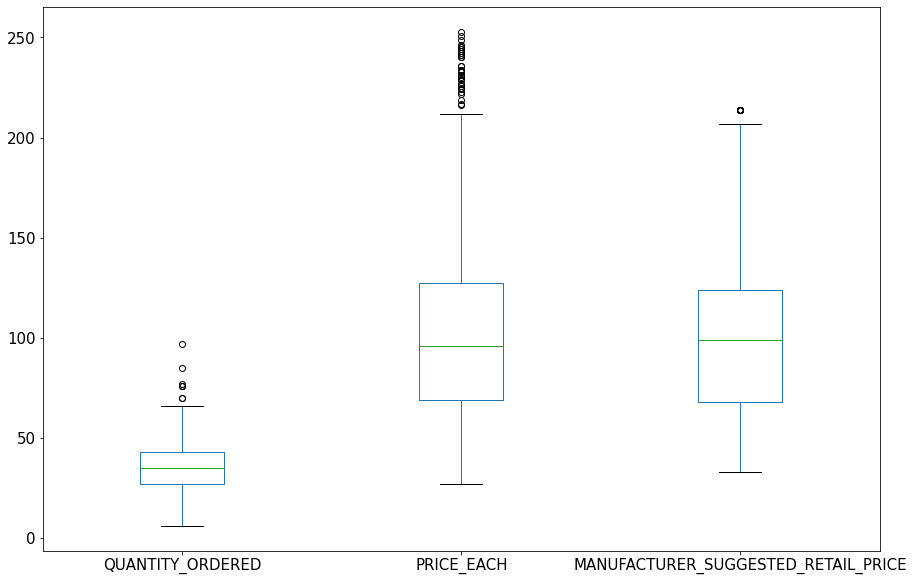

In [24]:
boxplot_1 = data.boxplot(column = ['QUANTITY_ORDERED', 'PRICE_EACH', 'MANUFACTURER_SUGGESTED_RETAIL_PRICE'], figsize=(15, 10), grid = False, fontsize = 15)

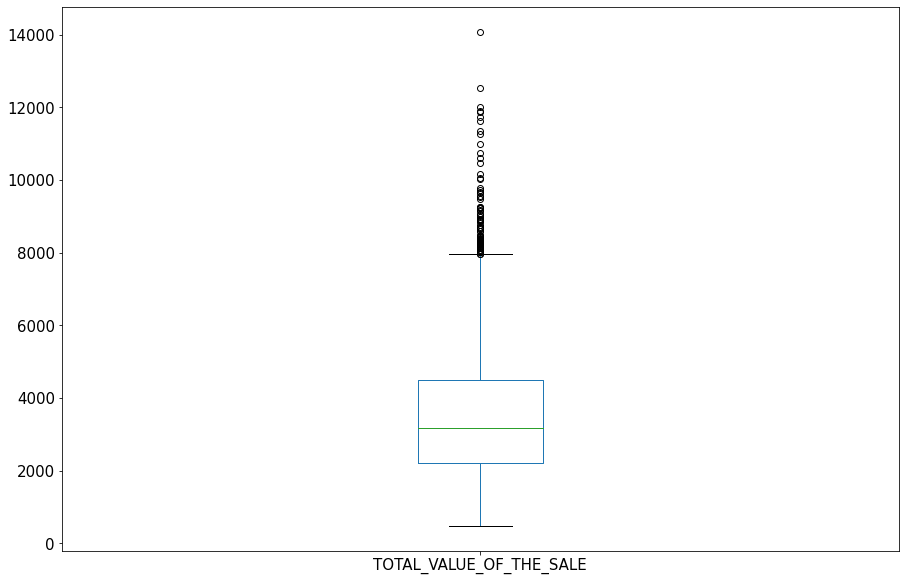

In [25]:
boxplot_2 = data.boxplot(column = 'TOTAL_VALUE_OF_THE_SALE', figsize=(15, 10), grid = False, fontsize = 15)

In [26]:
indexes_to_drop = []

for index in range(len(data['TOTAL_VALUE_OF_THE_SALE'])):
    if(data['TOTAL_VALUE_OF_THE_SALE'][index] > 8500):
        indexes_to_drop.append(index)
        
print('The number of values greater than 8500:', len(indexes_to_drop))

The number of values greater than 8500: 46


In [27]:
data = data.drop(indexes_to_drop, axis = 0)
data = data.reset_index(drop = True)

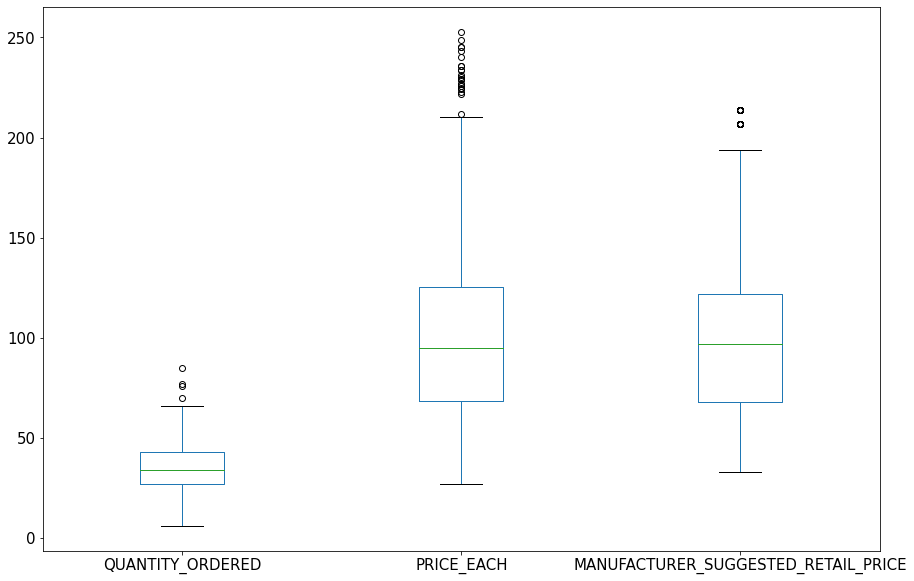

In [28]:
boxplot_3 = data.boxplot(column = ['QUANTITY_ORDERED', 'PRICE_EACH', 'MANUFACTURER_SUGGESTED_RETAIL_PRICE'], figsize=(15, 10), grid = False, fontsize = 15)

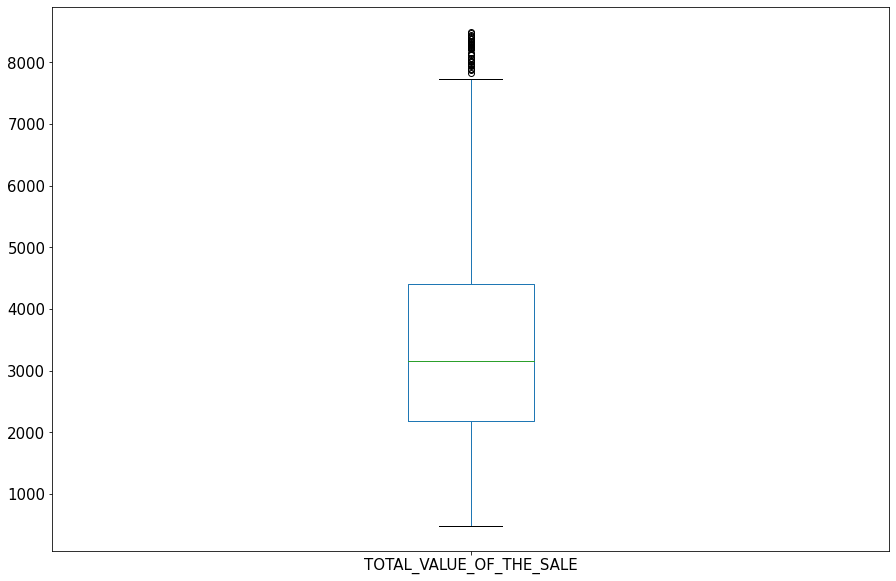

In [29]:
boxplot_4 = data.boxplot(column = 'TOTAL_VALUE_OF_THE_SALE', figsize=(15, 10), grid = False, fontsize = 15)

Histograms:

- all the histograms are a little bit skewed to the right

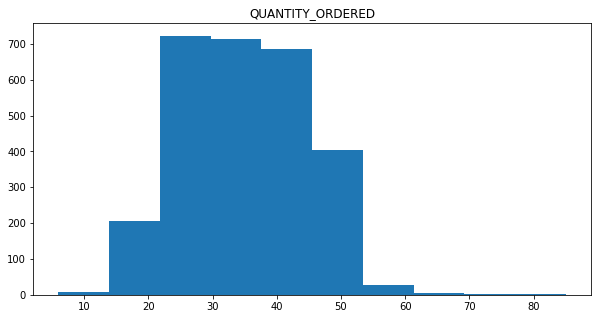

In [30]:
hist_1 = data.hist(column = 'QUANTITY_ORDERED', figsize=(10, 5), grid = False)

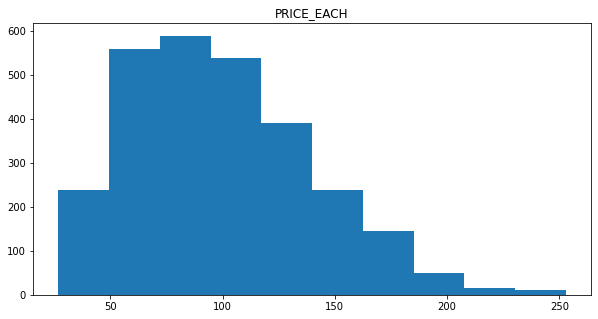

In [31]:
hist_2 = data.hist(column = 'PRICE_EACH', figsize=(10, 5), grid = False)

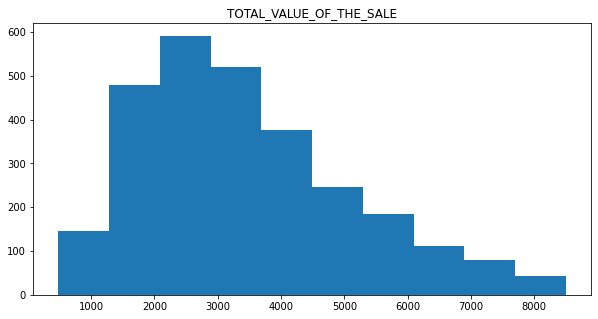

In [32]:
hist_3 = data.hist(column = 'TOTAL_VALUE_OF_THE_SALE', figsize=(10, 5), grid = False)

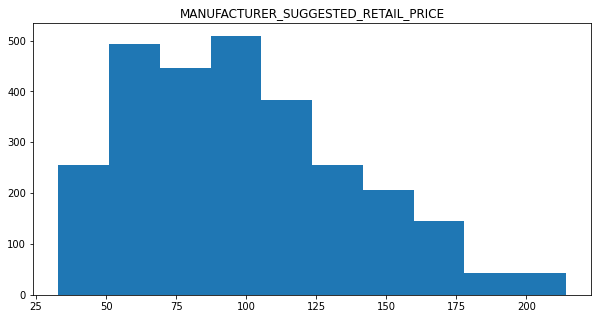

In [33]:
hist_4 = data.hist(column = 'MANUFACTURER_SUGGESTED_RETAIL_PRICE', figsize=(10, 5), grid = False)

# Customer segmentation with SOM

Calculate Recency, Frequency and Monetary value for each customer.

RFM (Recency, Frequency and Monetary value) is a method used for analyzing customer value.

- Recency : Recency is the number of days between the customer's latest order date and the global latest date.
- Frequency: Number of purchases made by the customer.
- Monetary Value: Revenue generated by the customer.

In [34]:
latest_date = data['ORDER_DATE'].max() + dt.timedelta(days = 1) # latest date in the data set
latest_date

datetime.date(2005, 6, 1)

In [35]:
data_RFM = data.groupby(['CUSTOMER_NAME']).agg({'ORDER_DATE': lambda x: (latest_date - x.max()).days, 
                                                'ORDER_NUMBER': 'count', 
                                                'TOTAL_VALUE_OF_THE_SALE': 'sum'})

# rename the columns
data_RFM.rename(columns = {'ORDER_DATE': 'Recency',
                           'ORDER_NUMBER': 'Frequency',
                           'TOTAL_VALUE_OF_THE_SALE': 'Monetary_Value'}, inplace = True)

In [36]:
data_RFM.head()

,Recency,Frequency,Monetary_Value
CUSTOMER_NAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


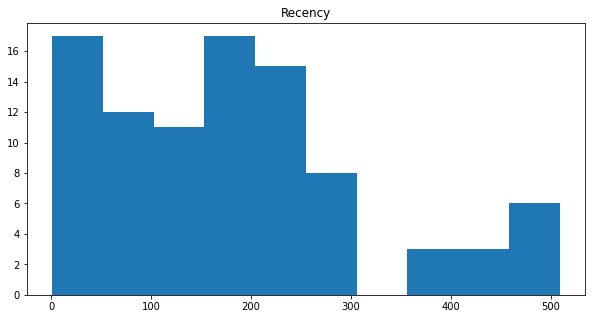

In [37]:
hist_5 = data_RFM.hist(column = 'Recency', figsize = (10, 5), grid = False)

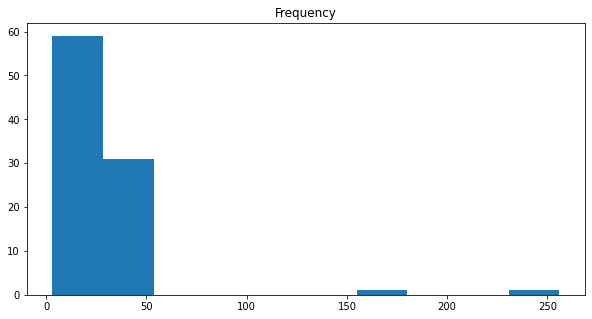

In [38]:
hist_6 = data_RFM.hist(column = 'Frequency', figsize = (10, 5), grid = False)

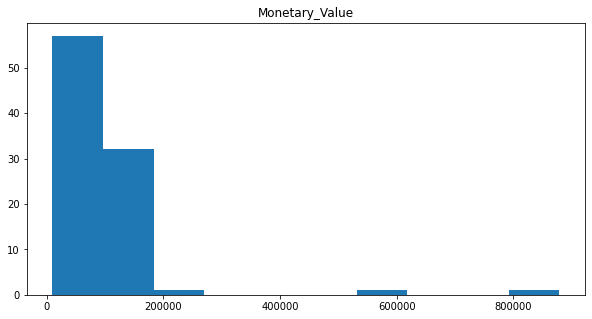

In [39]:
hist_7 = data_RFM.hist(column = 'Monetary_Value', figsize = (10, 5), grid = False)

In [40]:
log_data_RFM = np.log(data_RFM)
log_data_RFM.head()

,Recency,Frequency,Monetary_Value
CUSTOMER_NAME,,,
"AV Stores, Co.",5.278115,3.931826,11.969133
Alpha Cognac,4.174387,2.995732,11.163204
Amica Models & Co.,5.579730,3.258097,11.452297
"Anna's Decorations, Ltd",4.430817,3.828641,11.944683
Atelier graphique,5.236442,1.945910,10.093279


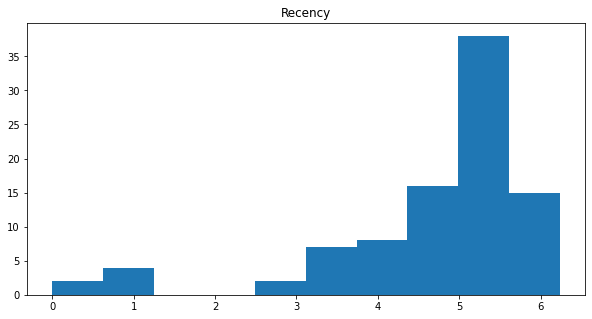

In [41]:
hist_8 = log_data_RFM.hist(column = 'Recency', figsize = (10, 5), grid = False)

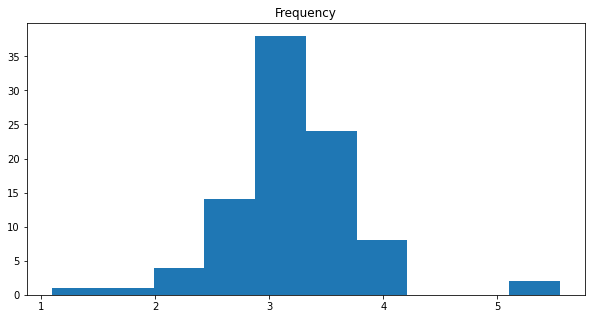

In [42]:
hist_9 = log_data_RFM.hist(column = 'Frequency', figsize = (10, 5), grid = False)

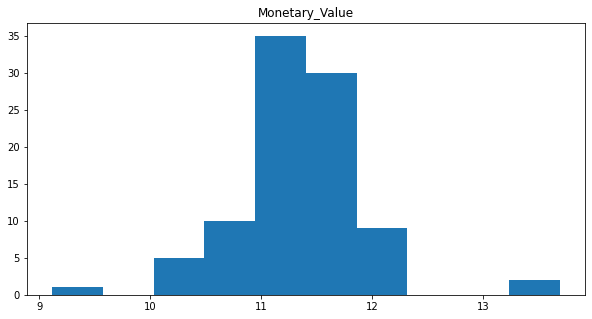

In [43]:
hist_10 = log_data_RFM.hist(column = 'Monetary_Value', figsize = (10, 5), grid = False)

SOM assumptions

In [44]:
# numeric data
# [0, 1] values (preferable)


# Advantages:

# They do not make assumptions regarding the distributions of variables and nor do they require independence
# among variables. Second, they are easier to implement and are able to solve nonlinear
# problems of very high complexity. Last, they more effectively cope with noisy and
# missing data, very small dimensionality and samples of unlimited size.

In [45]:
# 1.
log_data_RFM.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, AV Stores, Co. to giftsbymail.co.uk
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Recency         92 non-null     float64
 1   Frequency       92 non-null     float64
 2   Monetary_Value  92 non-null     float64
dtypes: float64(3)
memory usage: 2.9+ KB


In [46]:
# 2.
feature_scaler = MinMaxScaler(feature_range = (0, 1))
 
scaled_log_data_RFM = feature_scaler.fit_transform(log_data_RFM)
scaled_log_data_RFM = pd.DataFrame(data = scaled_log_data_RFM)
scaled_log_data_RFM.head()

,0,1,2
0,0.846877,0.637169,0.623948
1,0.669783,0.426648,0.447499
2,0.895271,0.485652,0.510793
3,0.710927,0.613964,0.618595
4,0.840190,0.190551,0.213252


Define parameters for SOM network

In [47]:
som_width = 8
som_length = 8
epochs = 10000
initial_learning_rate = 0.01
np.random.seed(10)

In [48]:
raws, cols = scaled_log_data_RFM.shape
print("Data set raw count = %d column count = %d." % (raws, cols))

Data set raw count = 92 column count = 3.


In [49]:
initial_radius = max(som_width, som_length) / 2
time_constant =  epochs / np.log(initial_radius)

In [50]:
som_net = np.random.random((som_width, som_length, cols))
print("Initial weights set to SOM network:")
print(som_net)

Initial weights set to SOM network:
[[[0.77132064 0.02075195 0.63364823]
  [0.74880388 0.49850701 0.22479665]
  [0.19806286 0.76053071 0.16911084]
  [0.08833981 0.68535982 0.95339335]
  [0.00394827 0.51219226 0.81262096]
  [0.61252607 0.72175532 0.29187607]
  [0.91777412 0.71457578 0.54254437]
  [0.14217005 0.37334076 0.67413362]]

 [[0.44183317 0.43401399 0.61776698]
  [0.51313824 0.65039718 0.60103895]
  [0.8052232  0.52164715 0.90864888]
  [0.31923609 0.09045935 0.30070006]
  [0.11398436 0.82868133 0.04689632]
  [0.62628715 0.54758616 0.819287  ]
  [0.19894754 0.8568503  0.35165264]
  [0.75464769 0.29596171 0.88393648]]

 [[0.32551164 0.1650159  0.39252924]
  [0.09346037 0.82110566 0.15115202]
  [0.38411445 0.94426071 0.98762547]
  [0.45630455 0.82612284 0.25137413]
  [0.59737165 0.90283176 0.53455795]
  [0.59020136 0.03928177 0.35718176]
  [0.07961309 0.30545992 0.33071931]
  [0.7738303  0.03995921 0.42949218]]

 [[0.31492687 0.63649114 0.34634715]
  [0.04309736 0.87991517 0.763240

Define basic functions needed to decay learning rate, radius and calculate Euclidian distance

In [51]:
def update_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def update_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_euclidian_dis(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

Logic to calculcate best matching unit

In [52]:
def find_best_matching_Unit(data_point):
    bmu_pos = np.array([0, 0])
    min_dist = np.iinfo(np.int).max
    input_dim = len(data_point)
    
    for x in range(som_width):
        for y in range(som_length):
            som_weight_vector = som_net[x, y, :].reshape(1, 3)
            euclidian_dist = calculate_euclidian_dis(som_weight_vector, data_point)
            if euclidian_dist < min_dist:
                min_dist = euclidian_dist
                bmu_pos = np.array([x, y])
    
    bmu = som_net[bmu_pos[0], bmu_pos[1], :].reshape(1, 3)
    return (bmu, bmu_pos)

Neighbourhood function to calculate influence from best matching unit and selected node

In [53]:
def neighbourhood_function(bmu_location, selected_node_location, radius):
    euclidien_dist_to_bmu = calculate_euclidian_dis(bmu_location, selected_node_location)
    return np.exp(- euclidien_dist_to_bmu / (2 * (radius ** 2)))

Train SOM network with our data set

In [54]:
# shuffle the data set
scaled_log_data_RFM = scaled_log_data_RFM.sample(frac = 1)

rad_values = list()
learn_rates_values = list()
rad_values.append(initial_radius)
learn_rates_values.append(initial_learning_rate)

for i in range(epochs):
    data_point = np.array(scaled_log_data_RFM.sample())
    bmu, bmu_idx = find_best_matching_Unit(data_point)

    r_new = update_radius(initial_radius, i, time_constant)
    new_learning_rate = update_learning_rate(initial_learning_rate, i, epochs)
    
    rad_values.append(r_new)
    learn_rates_values.append(new_learning_rate)
    
    for x in range(som_width):
        for y in range(som_length):
            w = som_net[x, y, :].reshape(1, 3)
            w_dist = calculate_euclidian_dis(np.array([x, y]), bmu_idx)
            
            if w_dist <= r_new:
                influence = neighbourhood_function(bmu, w, r_new)
                new_w = w + (new_learning_rate * influence * (data_point - w))
                som_net[x, y, :] = new_w.reshape(1, 3)   

Text(0.5, 1.0, 'Radius values')

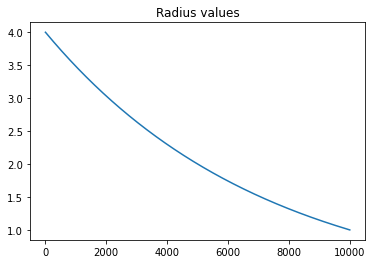

In [55]:
plt.plot(rad_values)
plt.title('Radius values')

Text(0.5, 1.0, 'Learning Rates values')

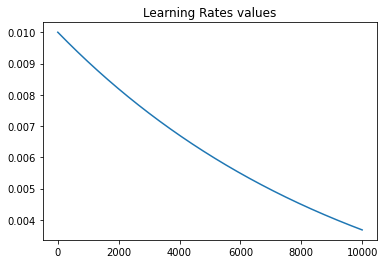

In [56]:
plt.plot(learn_rates_values)
plt.title('Learning Rates values')

Visualize the weights of the SOM after number of epoch times

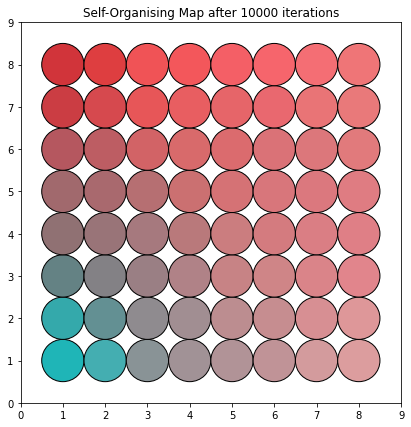

In [57]:
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_xlim((0, som_width + 1))
ax.set_ylim((0, som_length + 1))
ax.set_title('Self-Organising Map after %d iterations' % epochs)

for x in range(1, som_width + 1):
    for y in range(1, som_length + 1):
        ax.add_patch(patches.Circle((x, y), 0.5, facecolor = som_net[x-1, y-1,:], edgecolor = 'black'))
plt.show()

Dividing the customers into 3 groups

Recency / Frequency / Monetary_Value : Level 3 > Level 2 > Level 1

- Lower the recency, higher the Recency level
- Higher the number of orders, higher the Frequency level
- Higher the monetary value, higher the Monetary_Value level

In [58]:
data_RFM.head()

,Recency,Frequency,Monetary_Value
CUSTOMER_NAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [59]:
Recency_Labels = pd.qcut(data_RFM['Recency'], q = 3, labels = list(range(3, 0, -1)))
Frequency_Labels = pd.qcut(data_RFM['Frequency'], q = 3, labels = range(1, 4))
Monetary_Value_Labels = pd.qcut(data_RFM['Monetary_Value'], q = 3, labels = range(1, 4))

data_RFM['R'] = Recency_Labels
data_RFM['F'] = Frequency_Labels
data_RFM['M'] = Monetary_Value_Labels

data_RFM.head()

,Recency,Frequency,Monetary_Value,R,F,M
CUSTOMER_NAME,,,,,,
"AV Stores, Co.",196,51,157807.81,2,3,3
Alpha Cognac,65,20,70488.44,3,1,1
Amica Models & Co.,265,26,94117.26,1,2,2
"Anna's Decorations, Ltd",84,46,153996.13,3,3,3
Atelier graphique,188,7,24179.96,2,1,1


In [60]:
# Calculate RFM_Score
data_RFM['RFM_Score'] = data_RFM[['R', 'F', 'M']].sum(axis = 1)
data_RFM.head()

,Recency,Frequency,Monetary_Value,R,F,M,RFM_Score
CUSTOMER_NAME,,,,,,,
"AV Stores, Co.",196,51,157807.81,2,3,3,8.0
Alpha Cognac,65,20,70488.44,3,1,1,5.0
Amica Models & Co.,265,26,94117.26,1,2,2,5.0
"Anna's Decorations, Ltd",84,46,153996.13,3,3,3,9.0
Atelier graphique,188,7,24179.96,2,1,1,4.0


Labelling the levels

- RFM Score > 6 - High Value Customer
- RFM Score <= 6 and RFM Score >= 4 - Mid Value Customer
- RFM Score < 4 - Low Value Customer

In [61]:
def rfm_level(df):
    if np.bool(df['RFM_Score'] > 6):
        return 'High Value Customer'
    elif np.bool((df['RFM_Score'] <= 6) & (df['RFM_Score'] >= 4)):
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'

# Create a new variable: RFM_Level
data_RFM['RFM_Level'] = data_RFM.apply(rfm_level, axis = 1)

data_RFM.head()

,Recency,Frequency,Monetary_Value,R,F,M,RFM_Score,RFM_Level
CUSTOMER_NAME,,,,,,,,
"AV Stores, Co.",196,51,157807.81,2,3,3,8.0,High Value Customer
Alpha Cognac,65,20,70488.44,3,1,1,5.0,Mid Value Customer
Amica Models & Co.,265,26,94117.26,1,2,2,5.0,Mid Value Customer
"Anna's Decorations, Ltd",84,46,153996.13,3,3,3,9.0,High Value Customer
Atelier graphique,188,7,24179.96,2,1,1,4.0,Mid Value Customer


In [62]:
# analyzing customer segments
 
rfm_level_agg = data_RFM.groupby(['RFM_Level']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Value':['mean', 'count']}).round(1)

print(rfm_level_agg)

                    Recency Frequency Monetary_Value      
                       mean      mean           mean count
RFM_Level                                                 
High Value Customer   103.1      45.6       157630.3    38
Low Value Customer    354.8      15.5        52884.1    18
Mid Value Customer    181.0      21.2        73228.8    36


# RFM_Level classification

Split the data

In [63]:
total_len = len(data_RFM)
train_len = int(0.8 * total_len)

X_train = data_RFM.iloc[:, 0:3][:train_len]
X_test = data_RFM.iloc[:, 0:3][train_len:]

y_train = data_RFM['RFM_Level'][:train_len]
y_test = data_RFM['RFM_Level'][train_len:]

print("Length of train set x:", X_train.shape[0], "y:", y_train.shape[0])
print("Length of test set x:", X_test.shape[0], "y:", y_test.shape[0])

Length of train set x: 73 y: 73
Length of test set x: 19 y: 19


In [64]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [65]:
X_train.head()

,Recency,Frequency,Monetary_Value
CUSTOMER_NAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [66]:
X_test.head()

,Recency,Frequency,Monetary_Value
CUSTOMER_NAME,,,
Signal Collectibles Ltd.,477,15,50218.51
Signal Gift Stores,184,29,82751.08
Souveniers And Things Co.,3,46,151570.98
"Stylish Desk Decors, Co.",180,26,88804.50
Suominen Souveniers,146,29,103354.95


In [67]:
y_train.head()

,High Value Customer,Low Value Customer,Mid Value Customer
CUSTOMER_NAME,,,
"AV Stores, Co.",1,0,0
Alpha Cognac,0,0,1
Amica Models & Co.,0,0,1
"Anna's Decorations, Ltd",1,0,0
Atelier graphique,0,0,1


In [68]:
y_test.head()

,High Value Customer,Low Value Customer,Mid Value Customer
CUSTOMER_NAME,,,
Signal Collectibles Ltd.,0,1,0
Signal Gift Stores,0,0,1
Souveniers And Things Co.,1,0,0
"Stylish Desk Decors, Co.",0,0,1
Suominen Souveniers,1,0,0


Build the model

In [69]:
model = Sequential()
model.add(Dense(500, input_dim = 3, activation = 'relu'))
# model.add(Dense(500, activation = 'relu'))
# model.add(Dense(300, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               2000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1503      
Total params: 3,503
Trainable params: 3,503
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, verbose = 1)

Train on 73 samples, validate on 19 samples
Epoch 1/100
73/73 [==============================] - 0s 3ms/step - loss: 2480.1747 - accuracy: 0.2603 - val_loss: 2639.7483 - val_accuracy: 0.4211
Epoch 2/100
73/73 [==============================] - 0s 92us/step - loss: 2284.2799 - accuracy: 0.4110 - val_loss: 1206.7203 - val_accuracy: 0.4211
Epoch 3/100
73/73 [==============================] - 0s 97us/step - loss: 2034.4954 - accuracy: 0.3836 - val_loss: 623.6847 - val_accuracy: 0.4211
Epoch 4/100
73/73 [==============================] - 0s 104us/step - loss: 1947.9425 - accuracy: 0.3014 - val_loss: 603.4576 - val_accuracy: 0.4211
Epoch 5/100
73/73 [==============================] - 0s 85us/step - loss: 1693.5722 - accuracy: 0.4521 - val_loss: 495.3473 - val_accuracy: 0.4211
Epoch 6/100
73/73 [==============================] - 0s 72us/step - loss: 1840.7837 - accuracy: 0.3973 - val_loss: 1310.0822 - val_accuracy: 0.4211
Epoch 7/100
73/73 [==============================] - 0s 79us/step - los

Epoch 56/100
73/73 [==============================] - 0s 75us/step - loss: 1041.4242 - accuracy: 0.4110 - val_loss: 830.6151 - val_accuracy: 0.4211
Epoch 57/100
73/73 [==============================] - 0s 87us/step - loss: 703.6394 - accuracy: 0.4795 - val_loss: 1142.4451 - val_accuracy: 0.4211
Epoch 58/100
73/73 [==============================] - 0s 78us/step - loss: 1291.5519 - accuracy: 0.4247 - val_loss: 937.9075 - val_accuracy: 0.4211
Epoch 59/100
73/73 [==============================] - 0s 92us/step - loss: 1387.5443 - accuracy: 0.4110 - val_loss: 376.5732 - val_accuracy: 0.5263
Epoch 60/100
73/73 [==============================] - 0s 79us/step - loss: 1103.6027 - accuracy: 0.3973 - val_loss: 209.8081 - val_accuracy: 0.4211
Epoch 61/100
73/73 [==============================] - 0s 78us/step - loss: 1224.4988 - accuracy: 0.3562 - val_loss: 879.1295 - val_accuracy: 0.4211
Epoch 62/100
73/73 [==============================] - 0s 78us/step - loss: 1037.8906 - accuracy: 0.4247 - val_lo

Data augmentation

In [72]:
copy_1_data_RFM = data_RFM.copy()

In [73]:
copy_1_data_RFM['Recency'] = copy_1_data_RFM['Recency'] + 5
copy_1_data_RFM['Frequency'] = copy_1_data_RFM['Frequency'] + 5
copy_1_data_RFM['Monetary_Value'] = copy_1_data_RFM['Monetary_Value'] + 5

In [74]:
copy_1_data_RFM.head()

,Recency,Frequency,Monetary_Value,R,F,M,RFM_Score,RFM_Level
CUSTOMER_NAME,,,,,,,,
"AV Stores, Co.",201,56,157812.81,2,3,3,8.0,High Value Customer
Alpha Cognac,70,25,70493.44,3,1,1,5.0,Mid Value Customer
Amica Models & Co.,270,31,94122.26,1,2,2,5.0,Mid Value Customer
"Anna's Decorations, Ltd",89,51,154001.13,3,3,3,9.0,High Value Customer
Atelier graphique,193,12,24184.96,2,1,1,4.0,Mid Value Customer


In [75]:
copy_2_data_RFM = data_RFM.copy()

In [76]:
copy_2_data_RFM['Recency'] = copy_2_data_RFM['Recency'] - 5
copy_2_data_RFM['Frequency'] = copy_2_data_RFM['Frequency'] - 5
copy_2_data_RFM['Monetary_Value'] = copy_2_data_RFM['Monetary_Value'] - 5

In [77]:
copy_2_data_RFM.head()

,Recency,Frequency,Monetary_Value,R,F,M,RFM_Score,RFM_Level
CUSTOMER_NAME,,,,,,,,
"AV Stores, Co.",191,46,157802.81,2,3,3,8.0,High Value Customer
Alpha Cognac,60,15,70483.44,3,1,1,5.0,Mid Value Customer
Amica Models & Co.,260,21,94112.26,1,2,2,5.0,Mid Value Customer
"Anna's Decorations, Ltd",79,41,153991.13,3,3,3,9.0,High Value Customer
Atelier graphique,183,2,24174.96,2,1,1,4.0,Mid Value Customer


In [78]:
concatenated_data_RFM = pd.concat([data_RFM, copy_1_data_RFM, copy_2_data_RFM])

In [79]:
total_len = len(concatenated_data_RFM)
train_len = int(0.8 * total_len)

X_train = concatenated_data_RFM.iloc[:, 0:3][:train_len]
X_test = concatenated_data_RFM.iloc[:, 0:3][train_len:]

y_train = concatenated_data_RFM['RFM_Level'][:train_len]
y_test = concatenated_data_RFM['RFM_Level'][train_len:]

print("Length of train set x:", X_train.shape[0], "y:", y_train.shape[0])
print("Length of test set x:", X_test.shape[0], "y:", y_test.shape[0])

Length of train set x: 220 y: 220
Length of test set x: 56 y: 56


In [80]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [81]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, verbose = 1)

Train on 220 samples, validate on 56 samples
Epoch 1/100
220/220 [==============================] - 0s 53us/step - loss: 743.4391 - accuracy: 0.4318 - val_loss: 161.8897 - val_accuracy: 0.6071
Epoch 2/100
220/220 [==============================] - 0s 48us/step - loss: 693.8553 - accuracy: 0.4773 - val_loss: 599.3862 - val_accuracy: 0.5000
Epoch 3/100
220/220 [==============================] - 0s 56us/step - loss: 829.1051 - accuracy: 0.4364 - val_loss: 299.9150 - val_accuracy: 0.5179
Epoch 4/100
220/220 [==============================] - 0s 60us/step - loss: 756.7747 - accuracy: 0.4273 - val_loss: 399.7833 - val_accuracy: 0.4464
Epoch 5/100
220/220 [==============================] - 0s 56us/step - loss: 769.0820 - accuracy: 0.4182 - val_loss: 361.7580 - val_accuracy: 0.5000
Epoch 6/100
220/220 [==============================] - 0s 55us/step - loss: 800.3429 - accuracy: 0.4500 - val_loss: 172.5477 - val_accuracy: 0.5714
Epoch 7/100
220/220 [==============================] - 0s 56us/step

Epoch 56/100
220/220 [==============================] - 0s 63us/step - loss: 113.8035 - accuracy: 0.6364 - val_loss: 36.1213 - val_accuracy: 0.7857
Epoch 57/100
220/220 [==============================] - 0s 54us/step - loss: 136.7234 - accuracy: 0.6273 - val_loss: 38.6240 - val_accuracy: 0.6786
Epoch 58/100
220/220 [==============================] - 0s 58us/step - loss: 105.0778 - accuracy: 0.6636 - val_loss: 91.2273 - val_accuracy: 0.6071
Epoch 59/100
220/220 [==============================] - 0s 51us/step - loss: 142.7519 - accuracy: 0.6045 - val_loss: 50.9994 - val_accuracy: 0.7500
Epoch 60/100
220/220 [==============================] - 0s 56us/step - loss: 129.0153 - accuracy: 0.5909 - val_loss: 24.4172 - val_accuracy: 0.8571
Epoch 61/100
220/220 [==============================] - 0s 54us/step - loss: 130.7360 - accuracy: 0.5955 - val_loss: 42.7361 - val_accuracy: 0.6964
Epoch 62/100
220/220 [==============================] - 0s 58us/step - loss: 100.0798 - accuracy: 0.6409 - val_l

Predict one observation

In [82]:
prediction = model.predict(np.array(X_test.iloc[1]).reshape(1, 3))

In [83]:
prediction

array([[1., 0., 0.]], dtype=float32)

In [84]:
predicted_label = np.argmax(prediction, axis = 1)

In [85]:
predicted_label

array([0])

In [86]:
y_test.iloc[1]

High Value Customer    1
Low Value Customer     0
Mid Value Customer     0
Name: Gifts4AllAges.com, dtype: uint8

# Self-Organising Maps (first example) - Iris dataset

In [87]:
# https://www.kaggle.com/warunaw/self-organizing-maps/notebook

In [88]:
iris = datasets.load_iris()

In [89]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [90]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [91]:
iris.feature_names[0]

'sepal length (cm)'

In [92]:
df = pd.DataFrame({iris.feature_names[0]: iris.data[:, 0], iris.feature_names[1]: iris.data[:, 1],
                   iris.feature_names[2]: iris.data[:, 2], iris.feature_names[3]: iris.data[:, 3]
                  })

In [93]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [94]:
feature_scaler = MinMaxScaler(feature_range = (0, 1))

df_scaled = feature_scaler.fit_transform(df)
df_scaled = pd.DataFrame(data = df_scaled)
df_scaled.head()

,0,1,2,3
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


Define parameters for SOM network

In [95]:
som_width = 8
som_length = 8
epochs = 10000
initial_learning_rate = 0.01
np.random.seed(10)

In [96]:
raws, cols = df_scaled.shape
print("Data set raw count=%d column count=%d" % (raws, cols))

Data set raw count=150 column count=4


In [97]:
initial_radius = max(som_width, som_length) / 2
time_constant =  epochs / np.log(initial_radius)

In [98]:
som_net = np.random.random((som_width, som_length, cols))
print("Initial weights set to SOM network:")
print(som_net)

Initial weights set to SOM network:
[[[0.77132064 0.02075195 0.63364823 0.74880388]
  [0.49850701 0.22479665 0.19806286 0.76053071]
  [0.16911084 0.08833981 0.68535982 0.95339335]
  [0.00394827 0.51219226 0.81262096 0.61252607]
  [0.72175532 0.29187607 0.91777412 0.71457578]
  [0.54254437 0.14217005 0.37334076 0.67413362]
  [0.44183317 0.43401399 0.61776698 0.51313824]
  [0.65039718 0.60103895 0.8052232  0.52164715]]

 [[0.90864888 0.31923609 0.09045935 0.30070006]
  [0.11398436 0.82868133 0.04689632 0.62628715]
  [0.54758616 0.819287   0.19894754 0.8568503 ]
  [0.35165264 0.75464769 0.29596171 0.88393648]
  [0.32551164 0.1650159  0.39252924 0.09346037]
  [0.82110566 0.15115202 0.38411445 0.94426071]
  [0.98762547 0.45630455 0.82612284 0.25137413]
  [0.59737165 0.90283176 0.53455795 0.59020136]]

 [[0.03928177 0.35718176 0.07961309 0.30545992]
  [0.33071931 0.7738303  0.03995921 0.42949218]
  [0.31492687 0.63649114 0.34634715 0.04309736]
  [0.87991517 0.76324059 0.87809664 0.41750914]


Define basic functions needed to decay learning rate, radius and calculate Euclidian distance

In [99]:
def update_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def update_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_euclidian_dis(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

Logic to calculcate best matching unit

In [100]:
def find_best_matching_Unit(data_point):
    bmu_pos = np.array([0, 0])
    min_dist = np.iinfo(np.int).max
    input_dim = len(data_point)
    
    for x in range(som_width):
        for y in range(som_length):
            som_weight_vector = som_net[x, y, :].reshape(1, 4)
            euclidian_dist = calculate_euclidian_dis(som_weight_vector, data_point)
            if euclidian_dist < min_dist:
                min_dist = euclidian_dist
                bmu_pos = np.array([x, y])
    
    bmu = som_net[bmu_pos[0], bmu_pos[1], :].reshape(1, 4)
    return (bmu, bmu_pos)

Neighbourhood function to calculate influence from best matching unit and selected node

In [101]:
def neighbourhood_function(bmu_location, selected_node_location, radius):
    euclidien_dist_to_bmu = calculate_euclidian_dis(bmu_location, selected_node_location)
    return np.exp(-euclidien_dist_to_bmu / (2 * (radius ** 2)))

Train SOM network with Iris data set

In [102]:
# shuffle data set
df_scaled = df_scaled.sample(frac = 1)

rad_values = list()
learn_rates_values = list()
rad_values.append(initial_radius)
learn_rates_values.append(initial_learning_rate)

for i in range(epochs):
    data_point = np.array(df_scaled.sample())
    bmu, bmu_idx = find_best_matching_Unit(data_point)

    r_new = update_radius(initial_radius, i, time_constant)
    new_learning_rate = update_learning_rate(initial_learning_rate, i, epochs)
    
    rad_values.append(r_new)
    learn_rates_values.append(new_learning_rate)
    
    for x in range(som_width):
        for y in range(som_length):
            w = som_net[x, y, :].reshape(1, 4)
            w_dist = calculate_euclidian_dis(np.array([x, y]), bmu_idx)
            
            if w_dist <= r_new:
                influence = neighbourhood_function(bmu, w, r_new)
                new_w = w + (new_learning_rate * influence * (data_point - w))
                som_net[x, y, :] = new_w.reshape(1, 4)   

Text(0.5, 1.0, 'Radius values')

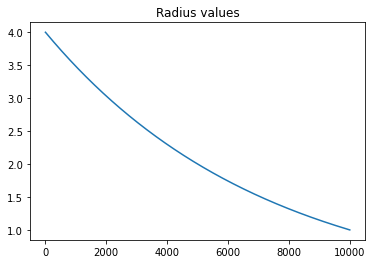

In [103]:
plt.plot(rad_values)
plt.title('Radius values')

Text(0.5, 1.0, 'Learning Rates values')

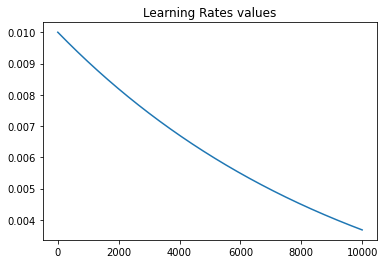

In [104]:
plt.plot(learn_rates_values)
plt.title('Learning Rates values')

Visualize the weights of the SOM after number of epoch times

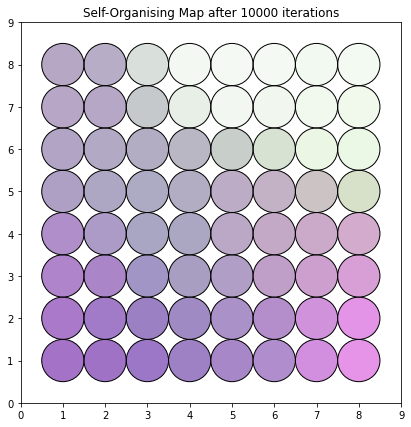

In [105]:
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(1, 1, 1, aspect = 'equal')
ax.set_xlim((0, som_width + 1))
ax.set_ylim((0, som_length + 1))
ax.set_title('Self-Organising Map after %d iterations' % epochs)

for x in range(1, som_width + 1):
    for y in range(1, som_length + 1):
        ax.add_patch(patches.Circle((x, y), 0.5, facecolor = som_net[x-1, y-1, :], edgecolor = 'black'))
plt.show()

# Self-Organising Maps (second example) - RGB model

In [106]:
# http://www.ai-junkie.com/ann/som/som4.html
# http://blog.yhat.com/posts/self-organizing-maps-2.html

In [107]:
raw_data = np.random.randint(0, 255, (3, 100))

In [108]:
raw_data.shape

(3, 100)

SOM Setup

In [109]:
network_dimensions = np.array([5, 5])
n_iterations = 100000
init_learning_rate = 0.01

normalise_data = True

# if True, assume all data on common scale
# if False, normalise to [0 1] range along each column
normalise_by_column = False

In [110]:
# establish variables based on data
m = raw_data.shape[0]
n = raw_data.shape[1]

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

data = raw_data
# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data.max(axis = 0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = raw_data / data.max()

In [111]:
# setup random weights between 0 and 1
# weight matrix needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

SOM Function Definitions

In [112]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

In [113]:
(bmu, bmu_idx)

(array([[0.2185663 , 0.64772317, 0.07870244, 0.06314421]]), array([6, 7]))

In [114]:
# page 3, equation 2
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

In [115]:
# page 4, equation 4
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

In [116]:
# page 4, equation 6
# if distance is huge => the update will be small
def calculate_influence(distance, radius):
    return np.exp(-distance / (2 * (radius ** 2)))

SOM Learning

In [117]:
for i in range(n_iterations):
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r ** 2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 3)

Plot the Colour Map

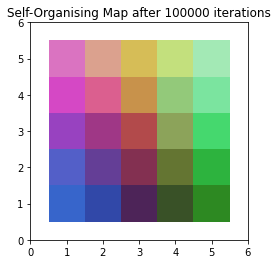

In [118]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect = 'equal')
ax.set_xlim((0, net.shape[0] + 1))
ax.set_ylim((0, net.shape[1] + 1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor = net[x-1, y-1, :],
                     edgecolor = 'none'))
plt.show()